In [2]:
import logging
logging.getLogger().setLevel(logging.ERROR)
from pathlib import Path
from collections import defaultdict

import numpy as np
from scipy import stats
from tqdm import tqdm
from matplotlib import pyplot as plt

from docembedder.preprocessor.preprocessor import Preprocessor
from docembedder.models import BERTEmbedder, TfidfEmbedder, D2VEmbedder, BPembEmbedder

In [2]:
data_dir = Path("..", "data")
unprocessed_dir = data_dir / "unprocessed"

### Create the models

In [4]:
models = {
    "sberta": BERTEmbedder("AI-Growth-Lab/PatentSBERTa"),
    "tfidf": TfidfEmbedder(),
    "doc2vec": D2VEmbedder(),
}
prep_skips = [{}, {"keep_caps": True}, {"keep_start_section": True}, {"remove_non_alpha": True}]
prep_models = {}
for skips in prep_skips:
    if len(skips):
        skip_name = list(skips)[0]
    else:
        skip_name = "all"
    prep_models[skip_name] = Preprocessor(**skips)

In [8]:
def classification_benchmark(patent_dicts, n_patent_sample, n_class_sample, start_year,
                             end_year):
    all_results = {}
    n_patents = len(patent_dicts["all"])
    if n_patents <= n_patent_sample:
        n_patent_sample = n_patents
    sampled_idx = np.random.choice(n_patents, size=n_patent_sample, replace=False)

    for patents_name, patents in patent_dicts.items():
        documents = [p["contents"] for p in patents]
        sampled_patents = [patents[i] for i in sampled_idx]
        sampled_documents = [documents[i] for i in sampled_idx]
        model_cor: Dict[str, Any] = {}
        for model_name, model in models.items():
            model_cor[model_name] = get_model_correlations(model, documents, sampled_documents)

        results = compare_classification_similarity(sampled_patents, model_cor,
                                                    class_fp=Path("..", "data", "GPCPCs.txt"),
                                                    n_sample=n_class_sample)
        for model_name, res in results.items():
            combi_name = model_name + "-" + patents_name
            all_results[combi_name] = res

        
    return all_results       

In [9]:
%%time
all_results = defaultdict(lambda: [])
all_years = []
n_patent_sample = 5000
n_class_sample = 20000
start_year, end_year = 1838, 1950

for fp in tqdm(list(unprocessed_dir.glob("*.xz"))):
    year = int(fp.stem)
    if year < start_year or year > end_year:
        continue
    patent_dicts = {
        prep_model_name: prep.preprocess_file(fp)[0] for prep_model_name, prep in prep_models.items()
    }
    if len(patent_dicts["all"]) < 100:
        continue
    results = classification_benchmark(patent_dicts, n_patent_sample, n_class_sample,
                                       start_year=start_year, end_year=end_year)

    all_years.append(year)
    for model_name, res in results.items():
        all_results[model_name].append(res)

100%|███████████████████████████████████| 114/114 [105:38:51<00:00, 3336.25s/it]

CPU times: user 7d 8h 43min 35s, sys: 1h 14min 29s, total: 7d 9h 58min 4s
Wall time: 4d 9h 38min 51s


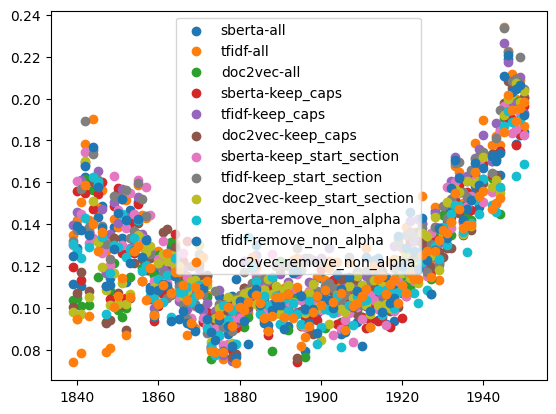

In [10]:
for model_name, res in all_results.items():
    plt.scatter(all_years, res, label=model_name)
plt.legend()
plt.show()

In [13]:
{name: np.mean(data) for name, data in all_results.items()}

{'sberta-all': 0.12189052163861804,
 'tfidf-all': 0.13045113108754822,
 'doc2vec-all': 0.11962020075528303,
 'sberta-keep_caps': 0.12056856341833455,
 'tfidf-keep_caps': 0.12991099034312356,
 'doc2vec-keep_caps': 0.12013486792336943,
 'sberta-keep_start_section': 0.12305190173480889,
 'tfidf-keep_start_section': 0.13089820698181115,
 'doc2vec-keep_start_section': 0.12116866890641516,
 'sberta-remove_non_alpha': 0.11764153347216305,
 'tfidf-remove_non_alpha': 0.12286294834867054,
 'doc2vec-remove_non_alpha': 0.11600100377986682}